In [76]:
from __future__ import annotations
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import unicodedata
from numpy.random import SeedSequence, default_rng
import ray


In [6]:
allstars = pd.read_table('all_stars_drama_raw.tsv')

In [7]:
allstars

,id,label,isGroup,gender,text,corpus,playName
0,mirvolin,Мирволин,False,MALE,"Здравствуй, Герасим! как поживаешь?.. А что, о...",rus,turgenev-zavtrak-u-predvoditelja
1,gerasim,Герасим,False,MALE,Здравствуйте. Где это вы достали лошадь?\nКто ...,rus,turgenev-zavtrak-u-predvoditelja
2,balagalaev,Балагалаев,False,MALE,"Филька! Вельвицкого мне позвать.\nТак, так, та...",rus,turgenev-zavtrak-u-predvoditelja
3,velvitskij,Вельвицкий,False,MALE,"Как же-с, как же-с.\nСлушаю-с. Так, стало быть...",rus,turgenev-zavtrak-u-predvoditelja
4,alupkin,Алупкин,False,MALE,"Доложи. А-а-лупкин, дворянин…\nПокорнейше благ...",rus,turgenev-zavtrak-u-predvoditelja
...,...,...,...,...,...,...,...
34481,SAILORS.TYRE.1_Per,Sailor,False,MALE,Where is Lord Helicanus ? He can resolve you ....,shake,pericles
34482,GENTLEMEN.TYRE.0.1_Per,Gentleman,False,MALE,Doth your Lordship call ?,shake,pericles
34483,SAILORS.MYTILENE.1_Per,Sailor,False,MALE,"Sir ,\nThis is the man that can , in aught you...",shake,pericles
34484,LORDS.MYTILENE.0.1_Per,Lord,False,MALE,"Sir , we have a maid in Mytilene ,\nI durst wa...",shake,pericles


In [8]:
allstars[allstars['text'].apply(lambda x: not isinstance(x, str))]

,id,label,isGroup,gender,text,corpus,playName
10968,le-docteur-sans-pareil,Le Docteur sans Pareil,False,UNKNOWN,NaN,fre,hervilly-docteur-sans-pareil
19609,der_klavierspieler,Der Klavierspieler,False,MALE,NaN,ger,schnitzler-zum-grossen-wurstel
19860,die_anderen_1-1,Die Anderen,True,MALE,NaN,ger,anzengruber-heimgfunden
19965,ein_knappe,Ein Knappe,False,MALE,NaN,ger,hebbel-agnes-bernauer
19975,schildknapp,Ein Schildknapp,False,MALE,NaN,ger,hebbel-agnes-bernauer
...,...,...,...,...,...,...,...
32779,dritter_herr,3. Herr,False,MALE,NaN,ger,chlumberg-die-fuehrer
32921,zehnte_gruppe,Zehnte Gruppe,True,UNKNOWN,NaN,ger,chlumberg-wunder-um-verdun
33030,die_magd,Die Magd,False,FEMALE,NaN,ger,bahr-das-konzert
33548,Epilogue_2H4,Epilogue,False,UNKNOWN,NaN,shake,henry-iv-part-ii


In [9]:
# drop all rows where the text isn't a string

allstars.drop(allstars[allstars['text'].apply(lambda x: not isinstance(x, str))].index, inplace=True)

In [10]:
allstars

,id,label,isGroup,gender,text,corpus,playName
0,mirvolin,Мирволин,False,MALE,"Здравствуй, Герасим! как поживаешь?.. А что, о...",rus,turgenev-zavtrak-u-predvoditelja
1,gerasim,Герасим,False,MALE,Здравствуйте. Где это вы достали лошадь?\nКто ...,rus,turgenev-zavtrak-u-predvoditelja
2,balagalaev,Балагалаев,False,MALE,"Филька! Вельвицкого мне позвать.\nТак, так, та...",rus,turgenev-zavtrak-u-predvoditelja
3,velvitskij,Вельвицкий,False,MALE,"Как же-с, как же-с.\nСлушаю-с. Так, стало быть...",rus,turgenev-zavtrak-u-predvoditelja
4,alupkin,Алупкин,False,MALE,"Доложи. А-а-лупкин, дворянин…\nПокорнейше благ...",rus,turgenev-zavtrak-u-predvoditelja
...,...,...,...,...,...,...,...
34481,SAILORS.TYRE.1_Per,Sailor,False,MALE,Where is Lord Helicanus ? He can resolve you ....,shake,pericles
34482,GENTLEMEN.TYRE.0.1_Per,Gentleman,False,MALE,Doth your Lordship call ?,shake,pericles
34483,SAILORS.MYTILENE.1_Per,Sailor,False,MALE,"Sir ,\nThis is the man that can , in aught you...",shake,pericles
34484,LORDS.MYTILENE.0.1_Per,Lord,False,MALE,"Sir , we have a maid in Mytilene ,\nI durst wa...",shake,pericles


In [12]:
def strip_punctuation(text: str) -> str:
    """
    >>> strip_punctuation(u'something')
    u'something'

    >>> strip_punctuation(u'something.,:else really')
    u'somethingelse really'
    """
    punctutation_cats = set(['Pc', 'Pd', 'Ps', 'Pe', 'Pi', 'Pf', 'Po'])
    return ''.join(x for x in text
                   if unicodedata.category(x) not in punctutation_cats)

In [13]:
def normalise_spaces(text: str) -> str:
    # by default, Python splits on any whitespace eg "a  \t\nb" -> ['a','b']
    return ' '.join(text.split()).strip()

In [14]:
strip_punctuation(normalise_spaces("Je suis      prêt à \t\tt'écouter, mon\n cher frère,")).lower()

'je suis prêt à técouter mon cher frère'

In [15]:
cleanText = allstars.text.map(lambda x: normalise_spaces(strip_punctuation(x).lower()))
allstars['cleanText'] = cleanText
allstars

,id,label,isGroup,gender,text,corpus,playName,cleanText
0,mirvolin,Мирволин,False,MALE,"Здравствуй, Герасим! как поживаешь?.. А что, о...",rus,turgenev-zavtrak-u-predvoditelja,здравствуй герасим как поживаешь а что он еще ...
1,gerasim,Герасим,False,MALE,Здравствуйте. Где это вы достали лошадь?\nКто ...,rus,turgenev-zavtrak-u-predvoditelja,здравствуйте где это вы достали лошадь кто пре...
2,balagalaev,Балагалаев,False,MALE,"Филька! Вельвицкого мне позвать.\nТак, так, та...",rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
3,velvitskij,Вельвицкий,False,MALE,"Как же-с, как же-с.\nСлушаю-с. Так, стало быть...",rus,turgenev-zavtrak-u-predvoditelja,как жес как жес слушаюс так стало бытьс бумаги...
4,alupkin,Алупкин,False,MALE,"Доложи. А-а-лупкин, дворянин…\nПокорнейше благ...",rus,turgenev-zavtrak-u-predvoditelja,доложи аалупкин дворянин покорнейше благодарю ...
...,...,...,...,...,...,...,...,...
34481,SAILORS.TYRE.1_Per,Sailor,False,MALE,Where is Lord Helicanus ? He can resolve you ....,shake,pericles,where is lord helicanus he can resolve you o h...
34482,GENTLEMEN.TYRE.0.1_Per,Gentleman,False,MALE,Doth your Lordship call ?,shake,pericles,doth your lordship call
34483,SAILORS.MYTILENE.1_Per,Sailor,False,MALE,"Sir ,\nThis is the man that can , in aught you...",shake,pericles,sir this is the man that can in aught you woul...
34484,LORDS.MYTILENE.0.1_Per,Lord,False,MALE,"Sir , we have a maid in Mytilene ,\nI durst wa...",shake,pericles,sir we have a maid in mytilene i durst wager w...


In [16]:
allstars_long = allstars[allstars.cleanText.apply(lambda x: 2000 < len(x.split(' ')))]
allstars_long

,id,label,isGroup,gender,text,corpus,playName,cleanText
2,balagalaev,Балагалаев,False,MALE,"Филька! Вельвицкого мне позвать.\nТак, так, та...",rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
21,darja_ivanovna,Дарья Ивановна,False,FEMALE,. Миша!\nВы… ходили к Попову?\nЧто он вам сказ...,rus,turgenev-provintsialka,миша вы ходили к попову что он вам сказал жду ...
27,graf_ljubin,Граф Любин,False,MALE,". Что же это значит? Никого нет, что ли? Зачем...",rus,turgenev-provintsialka,что же это значит никого нет что ли зачем этот...
28,donja_dolores,Донья Долорес,False,FEMALE,". Однако, мне очень скучно. — Мне нечего читат...",rus,turgenev-neostorozhnost,однако мне очень скучно мне нечего читать я не...
29,don_rafael,Дон Рафаэль,False,MALE,". Что бы вы сделали, прекрасная сеньйора?\n. С...",rus,turgenev-neostorozhnost,что бы вы сделали прекрасная сеньйора сеньйора...
...,...,...,...,...,...,...,...,...
34399,Cloten_Cym,Cloten,False,MALE,"If my shirt were bloody , then to shift it . H...",shake,cymbeline,if my shirt were bloody then to shift it have ...
34402,Iachimo_Cym,Iachimo,False,MALE,"Believe it , sir , I have seen him in Britain ...",shake,cymbeline,believe it sir i have seen him in britain he w...
34410,Belarius_Cym,Belarius,False,MALE,A goodly day not to keep house with such\nWhos...,shake,cymbeline,a goodly day not to keep house with such whose...
34432,Gower_Per,Gower,False,MALE,"To sing a song that old was sung ,\nFrom ashes...",shake,pericles,to sing a song that old was sung from ashes an...


In [259]:
allstars = pd.read_pickle('allstars_clean.pkl.zip')
allstars

,id,label,isGroup,gender,corpus,playName,cleanText
0,mirvolin,Мирволин,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,здравствуй герасим как поживаешь а что он еще ...
1,gerasim,Герасим,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,здравствуйте где это вы достали лошадь кто пре...
2,balagalaev,Балагалаев,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
3,velvitskij,Вельвицкий,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,как жес как жес слушаюс так стало бытьс бумаги...
4,alupkin,Алупкин,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,доложи аалупкин дворянин покорнейше благодарю ...
...,...,...,...,...,...,...,...
34481,SAILORS.TYRE.1_Per,Sailor,False,MALE,shake,pericles,where is lord helicanus he can resolve you o h...
34482,GENTLEMEN.TYRE.0.1_Per,Gentleman,False,MALE,shake,pericles,doth your lordship call
34483,SAILORS.MYTILENE.1_Per,Sailor,False,MALE,shake,pericles,sir this is the man that can in aught you woul...
34484,LORDS.MYTILENE.0.1_Per,Lord,False,MALE,shake,pericles,sir we have a maid in mytilene i durst wager w...


In [260]:
# The supplied id column is useless (full of duplicates) so
# let's just use a numeric id, which we'll need later for
# various things

allstars.id = allstars.index
allstars

,id,label,isGroup,gender,corpus,playName,cleanText
0,0,Мирволин,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,здравствуй герасим как поживаешь а что он еще ...
1,1,Герасим,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,здравствуйте где это вы достали лошадь кто пре...
2,2,Балагалаев,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
3,3,Вельвицкий,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,как жес как жес слушаюс так стало бытьс бумаги...
4,4,Алупкин,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,доложи аалупкин дворянин покорнейше благодарю ...
...,...,...,...,...,...,...,...
34481,34481,Sailor,False,MALE,shake,pericles,where is lord helicanus he can resolve you o h...
34482,34482,Gentleman,False,MALE,shake,pericles,doth your lordship call
34483,34483,Sailor,False,MALE,shake,pericles,sir this is the man that can in aught you woul...
34484,34484,Lord,False,MALE,shake,pericles,sir we have a maid in mytilene i durst wager w...


In [261]:
allstars.to_pickle('allstars_clean.pkl.zip')

In [262]:
# refilter (to keep the ids)

allstars_long = allstars[allstars.cleanText.apply(lambda x: 2000 < len(x.split(' ')))]
allstars_long

,id,label,isGroup,gender,corpus,playName,cleanText
2,2,Балагалаев,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
21,21,Дарья Ивановна,False,FEMALE,rus,turgenev-provintsialka,миша вы ходили к попову что он вам сказал жду ...
27,27,Граф Любин,False,MALE,rus,turgenev-provintsialka,что же это значит никого нет что ли зачем этот...
28,28,Донья Долорес,False,FEMALE,rus,turgenev-neostorozhnost,однако мне очень скучно мне нечего читать я не...
29,29,Дон Рафаэль,False,MALE,rus,turgenev-neostorozhnost,что бы вы сделали прекрасная сеньйора сеньйора...
...,...,...,...,...,...,...,...
34399,34399,Cloten,False,MALE,shake,cymbeline,if my shirt were bloody then to shift it have ...
34402,34402,Iachimo,False,MALE,shake,cymbeline,believe it sir i have seen him in britain he w...
34410,34410,Belarius,False,MALE,shake,cymbeline,a goodly day not to keep house with such whose...
34432,34432,Gower,False,MALE,shake,pericles,to sing a song that old was sung from ashes an...


In [263]:
allstars_long.to_pickle('allstars_long.pkl.zip')

In [3]:
allstars_long = pd.read_pickle('allstars_long.pkl.zip')
allstars_long

,id,label,isGroup,gender,corpus,playName,cleanText
2,balagalaev,Балагалаев,False,MALE,rus,turgenev-zavtrak-u-predvoditelja,филька вельвицкого мне позвать так так тактакт...
21,darja_ivanovna,Дарья Ивановна,False,FEMALE,rus,turgenev-provintsialka,миша вы ходили к попову что он вам сказал жду ...
27,graf_ljubin,Граф Любин,False,MALE,rus,turgenev-provintsialka,что же это значит никого нет что ли зачем этот...
28,donja_dolores,Донья Долорес,False,FEMALE,rus,turgenev-neostorozhnost,однако мне очень скучно мне нечего читать я не...
29,don_rafael,Дон Рафаэль,False,MALE,rus,turgenev-neostorozhnost,что бы вы сделали прекрасная сеньйора сеньйора...
...,...,...,...,...,...,...,...
34399,Cloten_Cym,Cloten,False,MALE,shake,cymbeline,if my shirt were bloody then to shift it have ...
34402,Iachimo_Cym,Iachimo,False,MALE,shake,cymbeline,believe it sir i have seen him in britain he w...
34410,Belarius_Cym,Belarius,False,MALE,shake,cymbeline,a goodly day not to keep house with such whose...
34432,Gower_Per,Gower,False,MALE,shake,pericles,to sing a song that old was sung from ashes an...


In [4]:
def threegrams(text: str)->list[str]:
    return [text[i:i+3] for i in range(len(text)-3+1)]

In [5]:
shake_ctr = Counter()
_ = allstars_long[allstars_long.corpus=="shake"].cleanText.map(lambda x: shake_ctr.update(threegrams(x)))
len(shake_ctr)

5921

In [29]:
shake_ctr.most_common(10)

[(' th', 42422),
 ('the', 24879),
 ('he ', 17327),
 ('nd ', 16951),
 ('and', 15140),
 (' an', 15044),
 ('is ', 12427),
 (' to', 12096),
 ('ll ', 11969),
 (' yo', 11762)]

In [30]:
pd.Series(shake_ctr.values()).describe()

count     5921.000000
mean       364.609525
std       1272.688895
min          1.000000
25%          4.000000
50%         31.000000
75%        207.000000
max      42422.000000
dtype: float64

In [6]:
def threegram_bag(df: pd.Series) -> np.ndarray:
    # need to dropna because some chars still yield 
    # no 3grams (maybe they say 'lo' or something) 
    # and explode turns that into nan
    return df.apply(threegrams).explode().dropna().values

In [7]:
def unique_threegrams(c: str) -> int:
    return len(set(threegram_bag(allstars_long[allstars_long.corpus==c].cleanText)))

In [8]:
def total_threegrams(c: str) -> int:
    return len(threegram_bag(allstars_long[allstars_long.corpus==c].cleanText))

In [9]:
[(c, unique_threegrams(c)) for c in allstars_long.corpus.unique()]

[('rus', 12542), ('fre', 9939), ('ger', 14289), ('shake', 5921)]

In [10]:
[(c, total_threegrams(c)/1_000_000) for c in allstars_long.corpus.unique()]

[('rus', 4.048757),
 ('fre', 29.722629),
 ('ger', 24.409509),
 ('shake', 2.158853)]

In [13]:
%load_ext rpy2.ipython

In [279]:

SS = SeedSequence(2022)

def bootstrap(a, b, cv, rng, n=999, alpha=0.05):
    
    # defining this in here to make sure it's in the same thread as this
    # invocation of bootstrap. rng is scoped into the closure below.
    
    def energy(a,b, cv):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([rng.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([rng.choice(b,10000)]).toarray()[0]
        return stats.energy_distance(samp1, samp2)
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = energy(a,b, cv)
    res.sort()
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

# this decorator lets us run this function as a Promise, so we start one
# running for each char and then +get+ the array of promises which will
# wait for them all to complete. Meanwhile, ray farms them out to all
# CPUs
@ray.remote
def char_results(char_id, char_name, pn, this_tg, other_tg, cv, rng):
    vocab_sz = len(set(this_tg))
    vocab_pct = vocab_sz/len(cv.get_feature_names_out())*100
    play_pct = len(this_tg)/(len(this_tg)+len(other_tg))*100
    # no need to parallelize these as well
    vs_other = bootstrap(this_tg, other_tg, cv, rng)
    vs_self = bootstrap(this_tg, this_tg, cv, rng)

    hsh = {
        'id':char_id,
        'Char':char_name,
        'Play':pn,
        'VocabSz':vocab_sz,
        'PctVocab':vocab_pct,
        'PctDialog':play_pct,
        'VersusSelf5':vs_self[0],
        'VersusSelf25':vs_self[1],
        'VersusSelf50':vs_self[2],
        'VersusSelf75':vs_self[3],
        'VersusSelf95':vs_self[4],
        'VersusOther5':vs_other[0],
        'VersusOther25':vs_other[1],
        'VersusOther50':vs_other[2],
        'VersusOther75':vs_other[3],
        'VersusOther95':vs_other[4],
    }
    return hsh

df_trim = allstars_long[allstars_long.corpus=='shake']
results = []

for pn, play_df in df_trim.groupby('playName'):
    all = allstars[(allstars.playName==pn)]
    all_threegrams = threegram_bag(all.cleanText)

    # We need a vectorizer that takes an existing sequence of 
    # 3-grams to work with the way we're doing sampling.
    cv = CountVectorizer(analyzer=lambda x: x)

    # Now we can transform any vector of 3-grams and the feature 
    # universes will all be the same. fit on the whole play to 
    # learn the full 3-gram vocab
    
    # CountVectorizer is threadsafe once fitted (afaik anyway)
    cv.fit([all_threegrams])

    for r in play_df.itertuples(index=False):
        others = allstars[(allstars.playName==r.playName) & (r.id != allstars.id)]
        this_char_threegrams = threegrams(r.cleanText)
        other_chars_threegrams = threegram_bag(others.cleanText)
        seed = SS.spawn(1)[0]
        # groupby etc is deterministic order, so this should all be reproducible
        rng = default_rng(seed)
        results.append(char_results.remote(r.id, r.label, pn, this_char_threegrams, other_chars_threegrams, cv, rng))

energy_df_shake = pd.DataFrame(ray.get(results))
# merge the genders back in from the original df, joining on our
# (now unique!) ids

energy_df_shake = energy_df_shake.merge(allstars[['id','gender']],on='id')


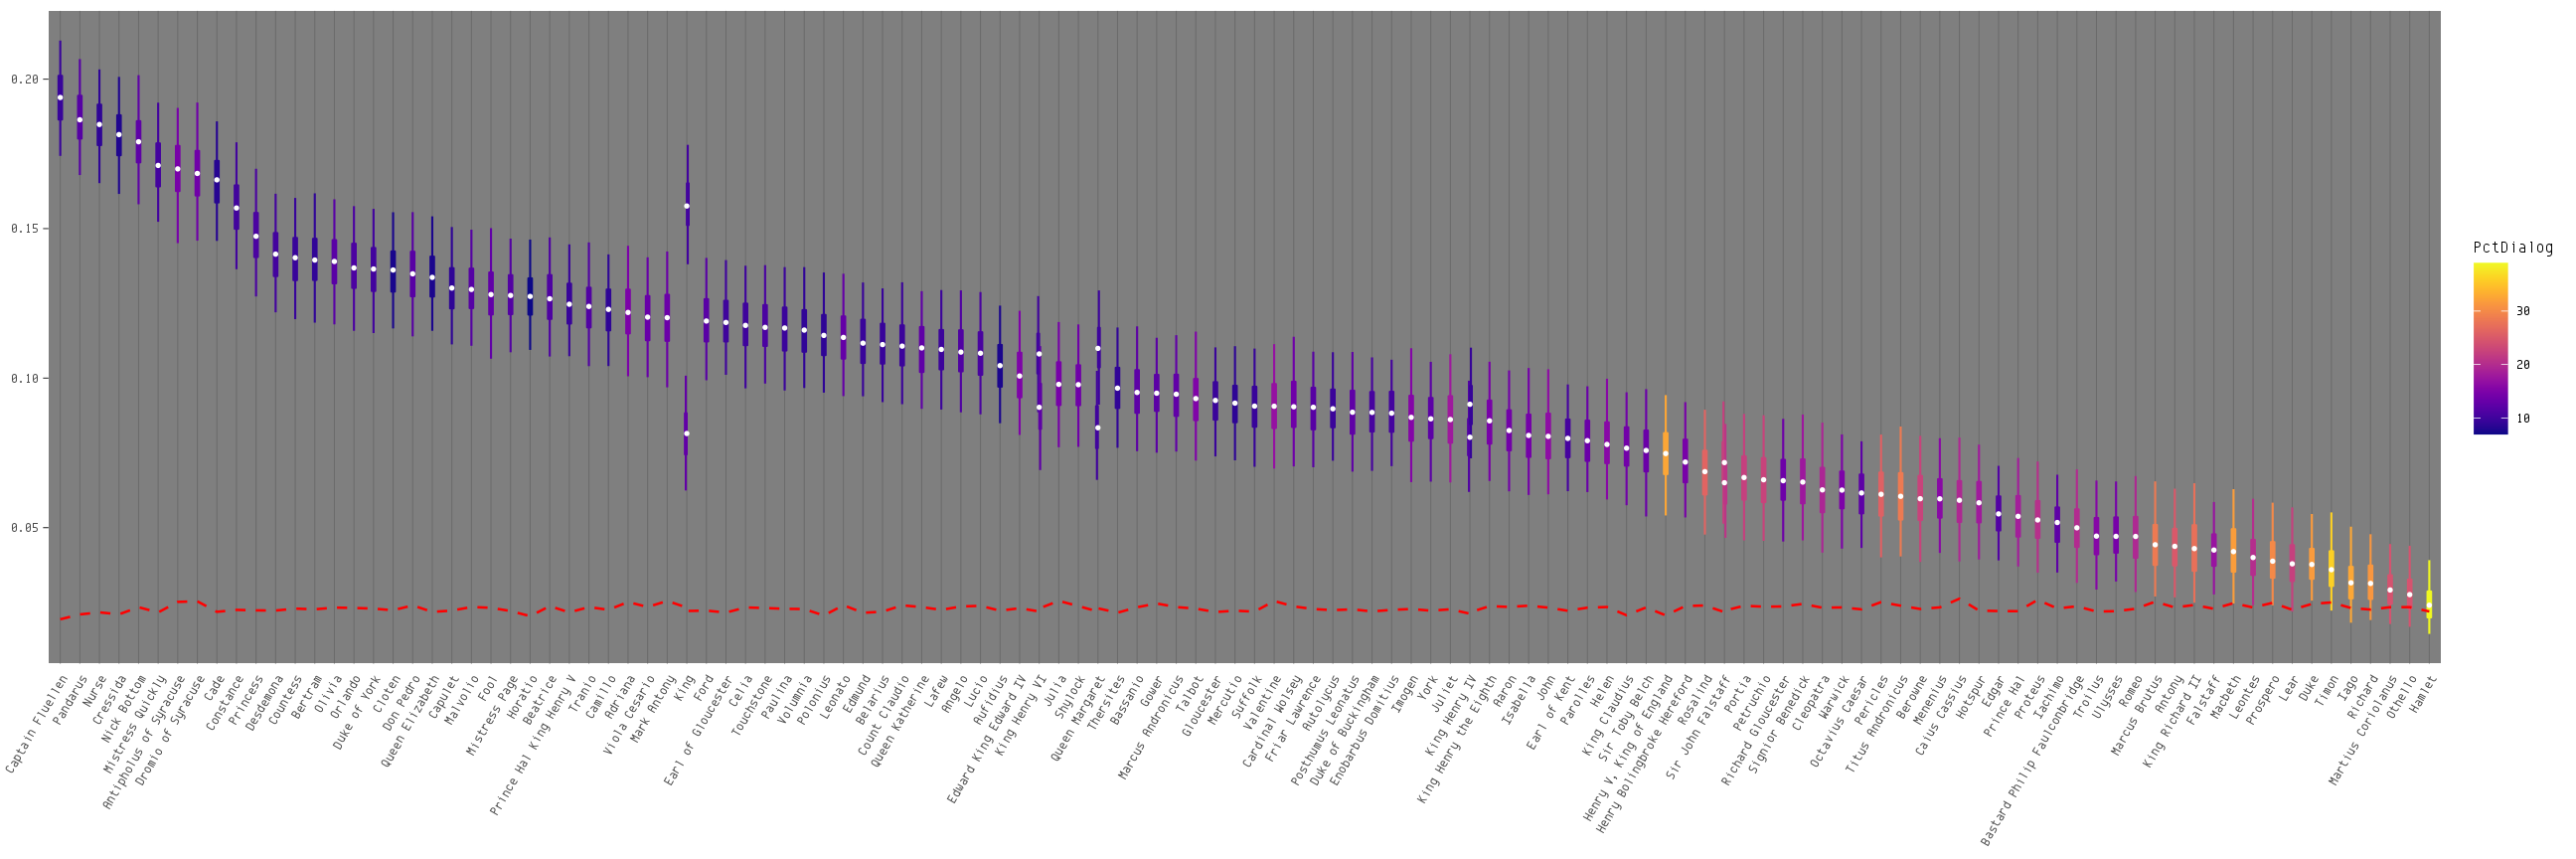

In [266]:
%%R -i energy_df_shake -h 6 -w 18 -u in -r 144
library(ggplot2)
library(viridis)

ggplot(energy_df_shake, aes(x=reorder(Char,-VersusOther50))) +
geom_boxplot(
    aes(
        lower = VersusOther25, 
        upper = VersusOther75, 
        middle = VersusOther50, 
        ymin = VersusOther5, 
        ymax = VersusOther95,
        color=PctDialog,
        fill=PctDialog,
        group=interaction(Char,Play)
    ),
    width = 0.2,
    stat = "identity"
) +
geom_point(aes(y = VersusOther50), color='white', size=0.6) +
geom_line(aes(y = VersusSelf50,group=1), color='red', size=0.6, linetype='dashed') +
scale_fill_viridis(option='plasma') +
scale_color_viridis(option='plasma',guide='none') +
theme_dark() +

theme(
    panel.border = element_blank(),
    #legend.position='none',
    axis.title.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    axis.text.x=element_text(angle = 60, hjust = 1),
    text=element_text(size=8, family="Envy Code R"),
)

In [278]:
df1 = energy_df_shake.copy()
df1

,id,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95,gender
0,33210,Nick Bottom,a-midsummer-night-s-dream,1661,50.090470,12.331866,0.015935,0.020622,0.023383,0.026634,0.035117,0.158140,0.172162,0.179046,0.185926,0.201329,MALE
1,33317,Countess,all-s-well-that-ends-well,1728,50.496786,9.456484,0.015606,0.020043,0.022921,0.026591,0.033139,0.119732,0.132776,0.140264,0.146885,0.160262,FEMALE
2,33318,Bertram,all-s-well-that-ends-well,1717,50.175336,8.952816,0.015094,0.019690,0.022681,0.026164,0.035656,0.118550,0.132838,0.139491,0.146597,0.161802,MALE
3,33319,Lafew,all-s-well-that-ends-well,1823,53.272940,9.727484,0.014832,0.019716,0.022492,0.026203,0.034911,0.089488,0.102940,0.109597,0.116089,0.129465,MALE
4,33320,Helen,all-s-well-that-ends-well,2105,61.513735,15.809836,0.015408,0.020017,0.023451,0.026872,0.034793,0.059413,0.071573,0.077825,0.085222,0.099803,FEMALE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,33355,Olivia,twelfth-night,1785,52.810651,11.995773,0.015396,0.020049,0.023258,0.027077,0.035685,0.117971,0.131716,0.139014,0.146138,0.159792,FEMALE
123,33356,Malvolio,twelfth-night,1765,52.218935,11.615324,0.015532,0.020283,0.023453,0.026739,0.034821,0.110809,0.123423,0.129653,0.136621,0.149644,MALE
124,33072,Valentine,two-gentlemen-of-verona,1949,62.870968,16.953437,0.017033,0.021783,0.025465,0.029190,0.038774,0.069749,0.083303,0.090596,0.098028,0.111370,MALE
125,33073,Proteus,two-gentlemen-of-verona,2134,68.838710,20.420915,0.016922,0.021964,0.025855,0.030137,0.039613,0.034946,0.046581,0.052564,0.058873,0.072108,MALE


In [280]:
# RUN ANALYSIS AGAIN FIRST

df2 = energy_df_shake.copy()
df2

,id,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95,gender
0,33210,Nick Bottom,a-midsummer-night-s-dream,1661,50.090470,12.331866,0.015935,0.020622,0.023383,0.026634,0.035117,0.158140,0.172162,0.179046,0.185926,0.201329,MALE
1,33317,Countess,all-s-well-that-ends-well,1728,50.496786,9.456484,0.015606,0.020043,0.022921,0.026591,0.033139,0.119732,0.132776,0.140264,0.146885,0.160262,FEMALE
2,33318,Bertram,all-s-well-that-ends-well,1717,50.175336,8.952816,0.015094,0.019690,0.022681,0.026164,0.035656,0.118550,0.132838,0.139491,0.146597,0.161802,MALE
3,33319,Lafew,all-s-well-that-ends-well,1823,53.272940,9.727484,0.014832,0.019716,0.022492,0.026203,0.034911,0.089488,0.102940,0.109597,0.116089,0.129465,MALE
4,33320,Helen,all-s-well-that-ends-well,2105,61.513735,15.809836,0.015408,0.020017,0.023451,0.026872,0.034793,0.059413,0.071573,0.077825,0.085222,0.099803,FEMALE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,33355,Olivia,twelfth-night,1785,52.810651,11.995773,0.015396,0.020049,0.023258,0.027077,0.035685,0.117971,0.131716,0.139014,0.146138,0.159792,FEMALE
123,33356,Malvolio,twelfth-night,1765,52.218935,11.615324,0.015532,0.020283,0.023453,0.026739,0.034821,0.110809,0.123423,0.129653,0.136621,0.149644,MALE
124,33072,Valentine,two-gentlemen-of-verona,1949,62.870968,16.953437,0.017033,0.021783,0.025465,0.029190,0.038774,0.069749,0.083303,0.090596,0.098028,0.111370,MALE
125,33073,Proteus,two-gentlemen-of-verona,2134,68.838710,20.420915,0.016922,0.021964,0.025855,0.030137,0.039613,0.034946,0.046581,0.052564,0.058873,0.072108,MALE


In [281]:
# OK seems like we have reproducible results

(df1.VersusSelf50 - df1.VersusSelf50).sum()

0.0

In [270]:
energy_df_shake.to_pickle('shakespeare_energy_dists.pkl.zip')

In [340]:
# Need to do something about this!

len(energy_df_shake[energy_df_shake.gender.isna()])

45

In [283]:

SS = SeedSequence(2022)

def bootstrap(a, b, cv, rng, n=999, alpha=0.05):
    
    # defining this in here to make sure it's in the same thread as this
    # invocation of bootstrap. rng is scoped into the closure below.
    
    def energy(a,b, cv):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([rng.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([rng.choice(b,10000)]).toarray()[0]
        return stats.energy_distance(samp1, samp2)
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = energy(a,b, cv)
    res.sort()
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

# this decorator lets us run this function as a Promise, so we start one
# running for each char and then +get+ the array of promises which will
# wait for them all to complete. Meanwhile, ray farms them out to all
# CPUs
@ray.remote
def char_results(char_id, char_name, pn, this_tg, other_tg, cv, rng):
    vocab_sz = len(set(this_tg))
    vocab_pct = vocab_sz/len(cv.get_feature_names_out())*100
    play_pct = len(this_tg)/(len(this_tg)+len(other_tg))*100
    # no need to parallelize these as well
    vs_other = bootstrap(this_tg, other_tg, cv, rng)
    vs_self = bootstrap(this_tg, this_tg, cv, rng)

    hsh = {
        'id':char_id,
        'Char':char_name,
        'Play':pn,
        'VocabSz':vocab_sz,
        'PctVocab':vocab_pct,
        'PctDialog':play_pct,
        'VersusSelf5':vs_self[0],
        'VersusSelf25':vs_self[1],
        'VersusSelf50':vs_self[2],
        'VersusSelf75':vs_self[3],
        'VersusSelf95':vs_self[4],
        'VersusOther5':vs_other[0],
        'VersusOther25':vs_other[1],
        'VersusOther50':vs_other[2],
        'VersusOther75':vs_other[3],
        'VersusOther95':vs_other[4],
    }
    return hsh

df_trim = allstars_long[allstars_long.corpus=='fre']
results = []

for pn, play_df in df_trim.groupby('playName'):
    all = allstars[(allstars.playName==pn)]
    if len(all) < 2:
        continue
        
    all_threegrams = threegram_bag(all.cleanText)

    # We need a vectorizer that takes an existing sequence of 
    # 3-grams to work with the way we're doing sampling.
    cv = CountVectorizer(analyzer=lambda x: x)

    # Now we can transform any vector of 3-grams and the feature 
    # universes will all be the same. fit on the whole play to 
    # learn the full 3-gram vocab
    
    # CountVectorizer is threadsafe once fitted (afaik anyway)
    cv.fit([all_threegrams])

    for r in play_df.itertuples(index=False):
        others = allstars[(allstars.playName==r.playName) & (r.id != allstars.id)]
        this_char_threegrams = threegrams(r.cleanText)
        other_chars_threegrams = threegram_bag(others.cleanText)
        seed = SS.spawn(1)[0]
        # groupby etc is deterministic order, so this should all be reproducible
        rng = default_rng(seed)
        results.append(char_results.remote(r.id, r.label, pn, this_char_threegrams, other_chars_threegrams, cv, rng))

energy_df_fre = pd.DataFrame(ray.get(results))

# merge the genders back in from the original df, joining on our
# (now unique!) ids

energy_df_fre = energy_df_fre.merge(allstars[['id','gender']],on='id')


In [90]:
allstars_long.corpus.unique()

array(['rus', 'fre', 'ger', 'shake'], dtype=object)

In [284]:
energy_df_fre

,id,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95,gender
0,3707,Argélie,abeille-argelie,2074,77.561705,25.511819,0.019432,0.025441,0.029758,0.034898,0.045001,0.029189,0.040118,0.045887,0.052447,0.064864,FEMALE
1,3710,Phoenix,abeille-argelie,1821,68.100224,19.849961,0.019746,0.025320,0.029151,0.033466,0.042376,0.082701,0.097437,0.105794,0.114523,0.129362,MALE
2,3711,Ismene,abeille-argelie,2087,78.047868,30.694993,0.019561,0.025342,0.029674,0.034259,0.045893,0.036968,0.048697,0.055328,0.063262,0.079746,FEMALE
3,3715,C. Martius,abeille-coriolan,2200,82.956259,36.380319,0.019637,0.025785,0.029700,0.034715,0.046794,0.023257,0.031067,0.036722,0.042009,0.053667,MALE
4,3718,Virgile,abeille-coriolan,1718,64.781297,18.811606,0.019491,0.025407,0.029120,0.033819,0.044335,0.090636,0.104661,0.113301,0.121832,0.135552,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,19229,Madeleine,zola-madeleine,1674,71.112999,38.274443,0.021877,0.028332,0.032530,0.037431,0.048518,0.095153,0.113839,0.122928,0.131861,0.150471,FEMALE
1740,19235,Laurent,zola-therese-raquin,1955,63.268608,17.936107,0.016565,0.022139,0.025193,0.028801,0.037277,0.050635,0.064803,0.071836,0.079548,0.093777,MALE
1741,19236,Therese,zola-therese-raquin,2052,66.407767,21.084844,0.017173,0.022328,0.025785,0.029682,0.038792,0.042909,0.056136,0.063189,0.070247,0.086257,UNKNOWN
1742,19237,Madame Raquin,zola-therese-raquin,1735,56.148867,14.797206,0.016704,0.021379,0.024850,0.028975,0.037680,0.110823,0.125611,0.132719,0.141234,0.154184,FEMALE


In [285]:
energy_df_fre.to_pickle('fre_energy_dists.pkl.zip')

In [288]:
energy_df_fre_restrict = energy_df_fre[energy_df_fre.PctDialog < 60]
energy_df_fre_restrict

,id,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95,gender
0,3707,Argélie,abeille-argelie,2074,77.561705,25.511819,0.019432,0.025441,0.029758,0.034898,0.045001,0.029189,0.040118,0.045887,0.052447,0.064864,FEMALE
1,3710,Phoenix,abeille-argelie,1821,68.100224,19.849961,0.019746,0.025320,0.029151,0.033466,0.042376,0.082701,0.097437,0.105794,0.114523,0.129362,MALE
2,3711,Ismene,abeille-argelie,2087,78.047868,30.694993,0.019561,0.025342,0.029674,0.034259,0.045893,0.036968,0.048697,0.055328,0.063262,0.079746,FEMALE
3,3715,C. Martius,abeille-coriolan,2200,82.956259,36.380319,0.019637,0.025785,0.029700,0.034715,0.046794,0.023257,0.031067,0.036722,0.042009,0.053667,MALE
4,3718,Virgile,abeille-coriolan,1718,64.781297,18.811606,0.019491,0.025407,0.029120,0.033819,0.044335,0.090636,0.104661,0.113301,0.121832,0.135552,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,19229,Madeleine,zola-madeleine,1674,71.112999,38.274443,0.021877,0.028332,0.032530,0.037431,0.048518,0.095153,0.113839,0.122928,0.131861,0.150471,FEMALE
1740,19235,Laurent,zola-therese-raquin,1955,63.268608,17.936107,0.016565,0.022139,0.025193,0.028801,0.037277,0.050635,0.064803,0.071836,0.079548,0.093777,MALE
1741,19236,Therese,zola-therese-raquin,2052,66.407767,21.084844,0.017173,0.022328,0.025785,0.029682,0.038792,0.042909,0.056136,0.063189,0.070247,0.086257,UNKNOWN
1742,19237,Madame Raquin,zola-therese-raquin,1735,56.148867,14.797206,0.016704,0.021379,0.024850,0.028975,0.037680,0.110823,0.125611,0.132719,0.141234,0.154184,FEMALE


In [290]:

SS = SeedSequence(2022)

def bootstrap(a, b, cv, rng, n=999, alpha=0.05):
    
    # defining this in here to make sure it's in the same thread as this
    # invocation of bootstrap. rng is scoped into the closure below.
    
    def energy(a,b, cv):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([rng.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([rng.choice(b,10000)]).toarray()[0]
        return stats.energy_distance(samp1, samp2)
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = energy(a,b, cv)
    res.sort()
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

# this decorator lets us run this function as a Promise, so we start one
# running for each char and then +get+ the array of promises which will
# wait for them all to complete. Meanwhile, ray farms them out to all
# CPUs
@ray.remote
def char_results(char_id, char_name, pn, this_tg, other_tg, cv, rng):
    vocab_sz = len(set(this_tg))
    vocab_pct = vocab_sz/len(cv.get_feature_names_out())*100
    play_pct = len(this_tg)/(len(this_tg)+len(other_tg))*100
    # no need to parallelize these as well
    vs_other = bootstrap(this_tg, other_tg, cv, rng)
    vs_self = bootstrap(this_tg, this_tg, cv, rng)

    hsh = {
        'id':char_id,
        'Char':char_name,
        'Play':pn,
        'VocabSz':vocab_sz,
        'PctVocab':vocab_pct,
        'PctDialog':play_pct,
        'VersusSelf5':vs_self[0],
        'VersusSelf25':vs_self[1],
        'VersusSelf50':vs_self[2],
        'VersusSelf75':vs_self[3],
        'VersusSelf95':vs_self[4],
        'VersusOther5':vs_other[0],
        'VersusOther25':vs_other[1],
        'VersusOther50':vs_other[2],
        'VersusOther75':vs_other[3],
        'VersusOther95':vs_other[4],
    }
    return hsh

df_trim = allstars_long[allstars_long.corpus=='ger']
results = []

for pn, play_df in df_trim.groupby('playName'):
    all = allstars[(allstars.playName==pn)]
    if len(all) < 2:
        continue
        
    all_threegrams = threegram_bag(all.cleanText)

    # We need a vectorizer that takes an existing sequence of 
    # 3-grams to work with the way we're doing sampling.
    cv = CountVectorizer(analyzer=lambda x: x)

    # Now we can transform any vector of 3-grams and the feature 
    # universes will all be the same. fit on the whole play to 
    # learn the full 3-gram vocab
    
    # CountVectorizer is threadsafe once fitted (afaik anyway)
    cv.fit([all_threegrams])

    for r in play_df.itertuples(index=False):
        others = allstars[(allstars.playName==r.playName) & (r.id != allstars.id)]
        this_char_threegrams = threegrams(r.cleanText)
        other_chars_threegrams = threegram_bag(others.cleanText)
        seed = SS.spawn(1)[0]
        # groupby etc is deterministic order, so this should all be reproducible
        rng = default_rng(seed)
        results.append(char_results.remote(r.id, r.label, pn, this_char_threegrams, other_chars_threegrams, cv, rng))

energy_df_ger = pd.DataFrame(ray.get(results))

# merge the genders back in from the original df, joining on our
# (now unique!) ids

energy_df_ger = energy_df_ger.merge(allstars[['id','gender']],on='id')


In [291]:
energy_df_ger

,id,Char,Play,VocabSz,PctVocab,PctDialog,VersusSelf5,VersusSelf25,VersusSelf50,VersusSelf75,VersusSelf95,VersusOther5,VersusOther25,VersusOther50,VersusOther75,VersusOther95,gender
0,22754,Gerlind,alberti-brot,2078,53.213828,13.080843,0.013541,0.017690,0.020371,0.023946,0.031622,0.060109,0.070923,0.077106,0.083432,0.095958,FEMALE
1,22770,Münzer,alberti-brot,2898,74.212548,36.100425,0.014017,0.017556,0.020640,0.024197,0.033053,0.016722,0.023019,0.027822,0.032894,0.044517,MALE
2,19924,Krawutschke,alberti-im-suff,1973,60.895062,30.695882,0.015990,0.020942,0.024630,0.028596,0.037523,0.106338,0.121969,0.129781,0.137463,0.151866,MALE
3,31883,Oront,andre-der-comoedienfeind,1714,74.456994,43.545240,0.022371,0.028815,0.033117,0.038464,0.049530,0.037349,0.050987,0.059009,0.066138,0.083699,MALE
4,21674,Grillhofer,anzengruber-der-gwissenswurm,2124,68.516129,28.774814,0.016436,0.021964,0.025555,0.029768,0.038796,0.044051,0.057041,0.064506,0.072674,0.087302,MALE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,25077,Abellino,zschokke-abellino,2522,59.621749,13.724574,0.012474,0.016643,0.019529,0.022567,0.030689,0.036357,0.047243,0.053660,0.059790,0.071084,MALE
1166,25079,Doge,zschokke-abellino,2730,64.539007,19.818972,0.012220,0.016460,0.019264,0.022611,0.030762,0.036074,0.047731,0.053946,0.059513,0.071332,MALE
1167,25083,Rosamunde,zschokke-abellino,2079,49.148936,10.147456,0.012302,0.016297,0.019165,0.021913,0.029368,0.102608,0.114766,0.121576,0.128343,0.140701,FEMALE
1168,25084,Flodoardo,zschokke-abellino,2303,54.444444,12.689092,0.012257,0.016324,0.019241,0.021888,0.029337,0.081724,0.093346,0.099836,0.106160,0.119370,MALE


In [292]:
energy_df_ger.to_pickle('ger_energy_dists.pkl.zip')

In [294]:
energy_df_ger_restrict = energy_df_ger[energy_df_ger.PctDialog < 60]


In [296]:

SS = SeedSequence(2022)

def bootstrap(a, b, cv, rng, n=999, alpha=0.05):
    
    # defining this in here to make sure it's in the same thread as this
    # invocation of bootstrap. rng is scoped into the closure below.
    
    def energy(a,b, cv):
        # +transform+ returns a 
        # sparse CSR matrix, which we convert to an np.ndarray and 
        # then take the first row. Samples are the same size, so we 
        # don't need to scale. np.random.choice is a sample with
        # replacement (normal for bootstrap samples)
        samp1 = cv.transform([rng.choice(a,10000)]).toarray()[0]
        samp2 = cv.transform([rng.choice(b,10000)]).toarray()[0]
        return stats.energy_distance(samp1, samp2)
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = energy(a,b, cv)
    res.sort()
    alphas = np.array([alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2])
    nvals = np.round((n - 1) * alphas).astype(int)
    return res[nvals]

# this decorator lets us run this function as a Promise, so we start one
# running for each char and then +get+ the array of promises which will
# wait for them all to complete. Meanwhile, ray farms them out to all
# CPUs
@ray.remote
def char_results(char_id, char_name, pn, this_tg, other_tg, cv, rng):
    vocab_sz = len(set(this_tg))
    vocab_pct = vocab_sz/len(cv.get_feature_names_out())*100
    play_pct = len(this_tg)/(len(this_tg)+len(other_tg))*100
    # no need to parallelize these as well
    vs_other = bootstrap(this_tg, other_tg, cv, rng)
    vs_self = bootstrap(this_tg, this_tg, cv, rng)

    hsh = {
        'id':char_id,
        'Char':char_name,
        'Play':pn,
        'VocabSz':vocab_sz,
        'PctVocab':vocab_pct,
        'PctDialog':play_pct,
        'VersusSelf5':vs_self[0],
        'VersusSelf25':vs_self[1],
        'VersusSelf50':vs_self[2],
        'VersusSelf75':vs_self[3],
        'VersusSelf95':vs_self[4],
        'VersusOther5':vs_other[0],
        'VersusOther25':vs_other[1],
        'VersusOther50':vs_other[2],
        'VersusOther75':vs_other[3],
        'VersusOther95':vs_other[4],
    }
    return hsh

df_trim = allstars_long[allstars_long.corpus=='rus']
results = []

for pn, play_df in df_trim.groupby('playName'):
    all = allstars[(allstars.playName==pn)]
    if len(all) < 2:
        continue
        
    all_threegrams = threegram_bag(all.cleanText)

    # We need a vectorizer that takes an existing sequence of 
    # 3-grams to work with the way we're doing sampling.
    cv = CountVectorizer(analyzer=lambda x: x)

    # Now we can transform any vector of 3-grams and the feature 
    # universes will all be the same. fit on the whole play to 
    # learn the full 3-gram vocab
    
    # CountVectorizer is threadsafe once fitted (afaik anyway)
    cv.fit([all_threegrams])

    for r in play_df.itertuples(index=False):
        others = allstars[(allstars.playName==r.playName) & (r.id != allstars.id)]
        this_char_threegrams = threegrams(r.cleanText)
        other_chars_threegrams = threegram_bag(others.cleanText)
        seed = SS.spawn(1)[0]
        # groupby etc is deterministic order, so this should all be reproducible
        rng = default_rng(seed)
        results.append(char_results.remote(r.id, r.label, pn, this_char_threegrams, other_chars_threegrams, cv, rng))

energy_df_rus = pd.DataFrame(ray.get(results))

# merge the genders back in from the original df, joining on our
# (now unique!) ids

energy_df_rus = energy_df_rus.merge(allstars[['id','gender']],on='id')


In [297]:
energy_df_rus.to_pickle('rus_energy_dists.pkl.zip')

In [298]:
energy_df_rus_restrict = energy_df_rus[energy_df_rus.PctDialog < 60]


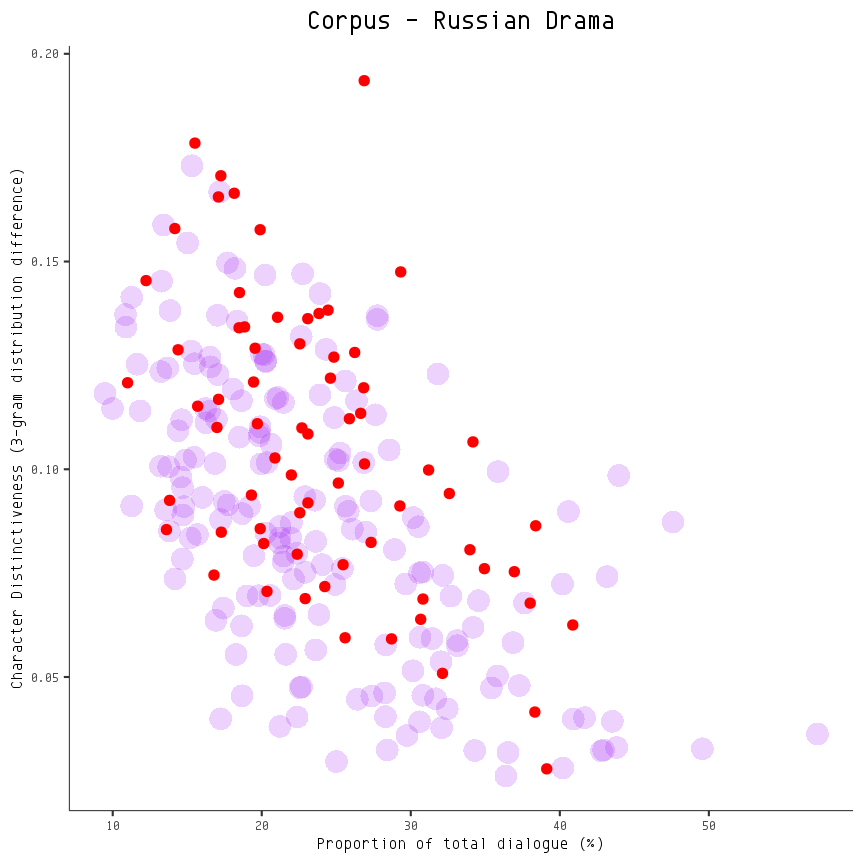

In [442]:
%%R -i energy_df_rus_restrict -h 6 -w 6 -u in -r 144
library(ggplot2)
library(dplyr)

ggplot(energy_df_rus_restrict, aes(y=VersusOther50, x = PctDialog)) +
geom_point(data = energy_df_rus_restrict %>% filter(gender!='FEMALE'), color='purple', size=5, shape=16, alpha=0.2) +
geom_point(data = energy_df_rus_restrict %>% filter(gender=='FEMALE'), color='red', size=2) +

theme_bw() +
xlab("Proportion of total dialogue (%)") +
ylab("Character Distinctiveness (3-gram distribution difference)") +
ggtitle("Corpus - Russian Drama") +
theme(
    panel.border = element_blank(),
    #legend.position='none',
    #axis.title.x=element_blank(),
    #axis.title.y=element_blank(),
    #axis.ticks.x=element_blank(),
    #axis.ticks.y=element_blank(),
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="Envy Code R"),
)

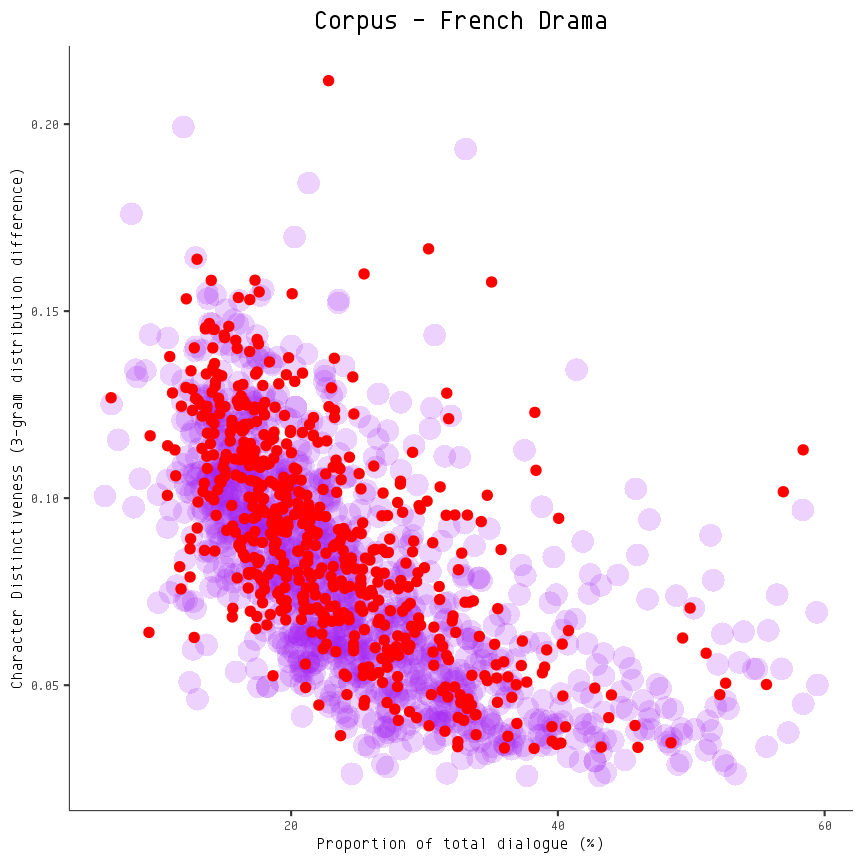

In [441]:
%%R -i energy_df_fre_restrict -h 6 -w 6 -u in -r 144
library(ggplot2)
library(dplyr)

ggplot(energy_df_rus_restrict, aes(y=VersusOther50, x = PctDialog)) +
geom_point(data = energy_df_fre_restrict %>% filter(gender!='FEMALE'), color='purple', size=5, shape=16, alpha=0.2) +
geom_point(data = energy_df_fre_restrict %>% filter(gender=='FEMALE'), color='red', size=2) +

theme_bw() +
xlab("Proportion of total dialogue (%)") +
ylab("Character Distinctiveness (3-gram distribution difference)") +
ggtitle("Corpus - French Drama") +
theme(
    panel.border = element_blank(),
    #legend.position='none',
    #axis.title.x=element_blank(),
    #axis.title.y=element_blank(),
    #axis.ticks.x=element_blank(),
    #axis.ticks.y=element_blank(),
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="Envy Code R"),
)

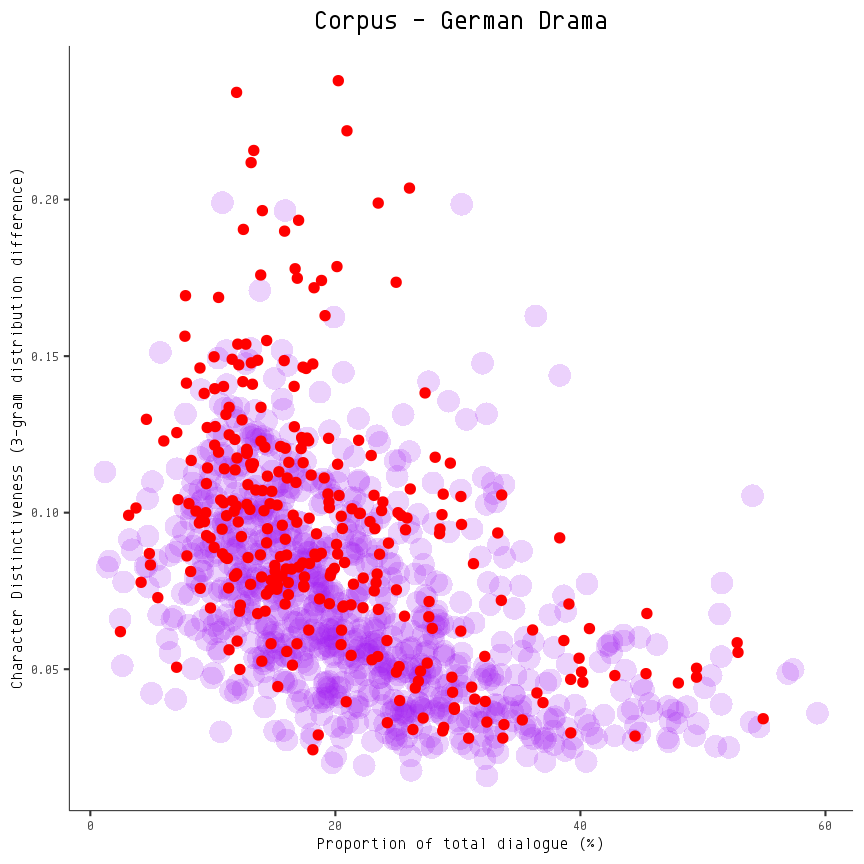

In [438]:
%%R -i energy_df_ger_restrict -h 6 -w 6 -u in -r 144
library(ggplot2)
library(dplyr)

ggplot(energy_df_rus_restrict, aes(y=VersusOther50, x = PctDialog)) +
geom_point(data = energy_df_ger_restrict %>% filter(gender!='FEMALE'), color='purple', size=5, shape=16, alpha=0.2) +
geom_point(data = energy_df_ger_restrict %>% filter(gender=='FEMALE'), color='red', size=2) +

theme_bw() +
xlab("Proportion of total dialogue (%)") +
ylab("Character Distinctiveness (3-gram distribution difference)") +
ggtitle("Corpus - German Drama") +
theme(
    panel.border = element_blank(),
    #legend.position='none',
    #axis.title.x=element_blank(),
    #axis.title.y=element_blank(),
    #axis.ticks.x=element_blank(),
    #axis.ticks.y=element_blank(),
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="Envy Code R"),
)

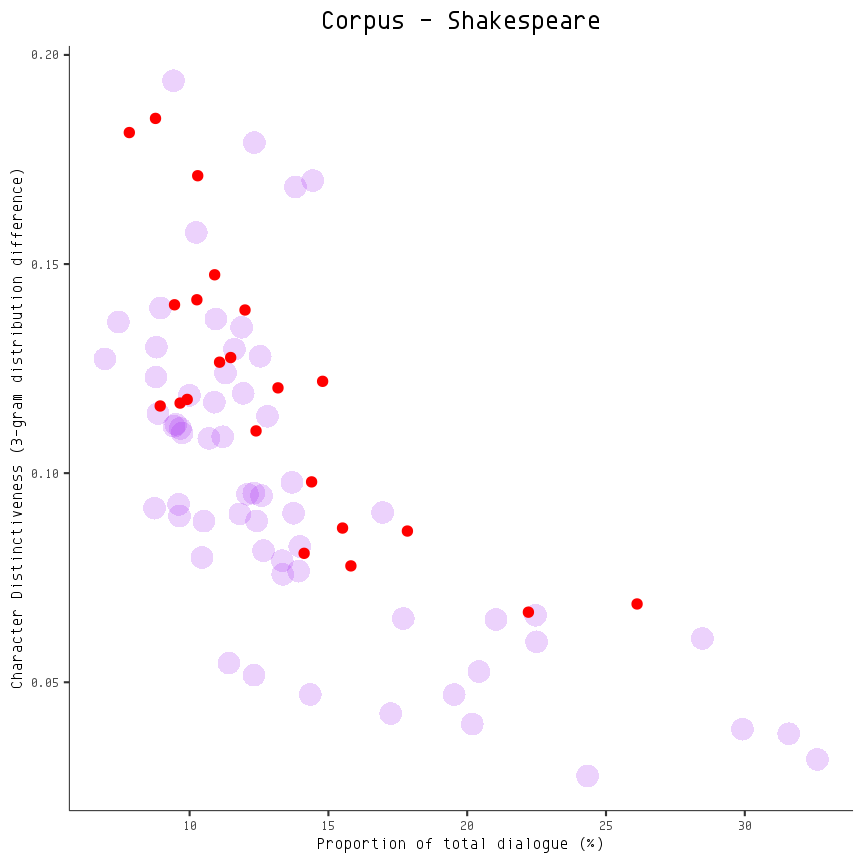

In [439]:
%%R -i energy_df_shake -h 6 -w 6 -u in -r 144
library(ggplot2)
library(dplyr)

ggplot(energy_df_rus_restrict, aes(y=VersusOther50, x = PctDialog)) +
geom_point(data = energy_df_shake %>% filter(gender!='FEMALE'), color='purple', size=5, shape=16, alpha=0.2) +
geom_point(data = energy_df_shake %>% filter(gender=='FEMALE'), color='red', size=2) +

theme_bw() +
xlab("Proportion of total dialogue (%)") +
ylab("Character Distinctiveness (3-gram distribution difference)") +
ggtitle("Corpus - Shakespeare") +
theme(
    panel.border = element_blank(),
    #legend.position='none',
    #axis.title.x=element_blank(),
    #axis.title.y=element_blank(),
    #axis.ticks.x=element_blank(),
    #axis.ticks.y=element_blank(),
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="Envy Code R"),
)

In [382]:
ger_vocab = pd.DataFrame(energy_df_ger.VocabSz)
ger_vocab['Corpus'] = 'ger'

fre_vocab = pd.DataFrame(energy_df_fre.VocabSz)
fre_vocab['Corpus'] = 'fre'

rus_vocab = pd.DataFrame(energy_df_rus.VocabSz)
rus_vocab['Corpus'] = 'rus'

shake_vocab = pd.DataFrame(energy_df_shake.VocabSz)
shake_vocab['Corpus'] = 'shake'

vocab_df = pd.concat([ger_vocab, fre_vocab, rus_vocab, shake_vocab])
vocab_df



,VocabSz,Corpus
0,2078,ger
1,2898,ger
2,1973,ger
3,1714,ger
4,2124,ger
...,...,...
122,1785,shake
123,1765,shake
124,1949,shake
125,2134,shake


In [443]:
vocab_df.to_pickle('vocab_df.pkl.zip')

R[write to console]: Picking joint bandwidth of 76.7



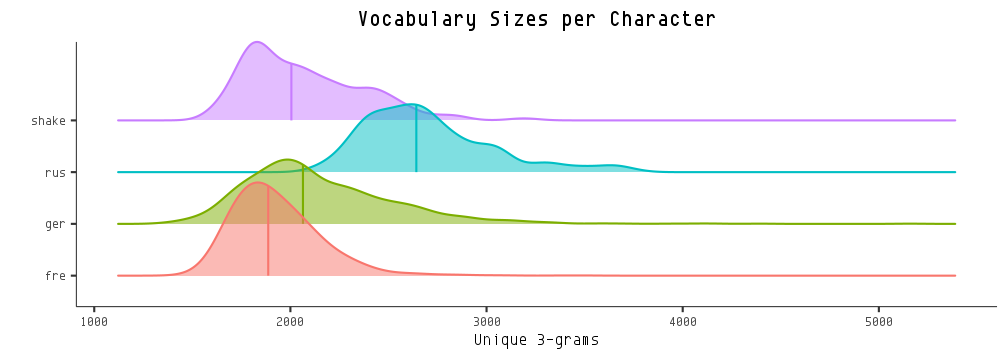

In [433]:
%%R -i vocab_df -h 2.5 -w 7 -u in -r 144
library(ggridges)

g_ridges <- 
  ggplot(vocab_df, aes(VocabSz, Corpus, fill = Corpus, color=Corpus)) +
  coord_cartesian(clip = "off")

g_ridges +

  
ggridges::stat_density_ridges(
    quantile_lines = TRUE, quantiles = 2, 
    alpha = .5, size = 0.5
) +
    
theme_bw() +
xlab("Unique 3-grams") +
ylab("") +
ggtitle("Vocabulary Sizes per Character") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    #axis.title.x=element_blank(),
    #axis.title.y=element_blank(),
    #axis.ticks.x=element_blank(),
    #axis.ticks.y=element_blank(),
    plot.title = element_text(hjust = 0.5, size=11),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="Envy Code R"),
)